# Auto Claims Data Load

## Install required packages

In [20]:
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install dask
# !pip install matplotlib
# !pip install statsmodels
# !pip install seaborn

     -------------------------------------- 292.8/292.8 kB 2.3 MB/s eta 0:00:00


## Load Packages

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
import statsmodels.api as sm

random.seed(81422)

%matplotlib inline

## Set up working directories

In [3]:
cwd = os.getcwd()

inputdir = "C:\\devl\\AutoClaims\\data"
outputdir = "C:\\devl\\AutoClaims\\output"

## Read in Data

In [4]:
dat = pd.read_csv(inputdir + "\\train_set.csv")

C:\Users\kharu\AppData\Local\Temp\ipykernel_20544\2247785172.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(inputdir + "\\train_set.csv")


In [5]:
dat.head()

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,...,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
0,1,1,3,2005,2005,K,K.78,K.78.2,D,C,...,1.008912,0.261040,0.907793,-0.077998,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
1,2,2,2,2005,2003,Q,Q.22,Q.22.3,B,C,...,1.240851,0.432987,-0.726459,0.204785,O,-0.23153,-0.266117,-0.272337,-0.251419,0.0
2,3,3,1,2005,1998,AR,AR.41,AR.41.1,B,?,...,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
3,4,3,1,2006,1998,AR,AR.41,AR.41.1,B,?,...,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
4,5,3,2,2005,2001,D,D.20,D.20.0,J,C,...,0.812656,2.112691,1.534462,2.347260,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0


In [6]:
# Check data shape and number of unique households
print(dat.shape[0], "rows", "\n", \
      dat.shape[1], "columns", "\n", \
      dat['Household_ID'].nunique(), "unique households")


13184290 rows 
 35 columns 
 4309042 unique households


## Train/test splits

### Generate folds that:
    1. Stratify on claim / no claim
    2. Keep households and household vehicles within-folds to prevent data leakage

In [7]:
dat['Claim'] = dat['Claim_Amount'] > 0

In [16]:
dat['Claim'].mean()

0.007251433334673312

In [8]:
# extract unique HHIDs, reserve 20% for OOS testing, split rest into 5 folds
HHIDs = dat['Household_ID'].copy().unique()

random.shuffle(HHIDs)
# dat = dat.set_index('Household_ID').loc[HHIDs].reset_index()

In [9]:
n_folds = 8 #5 for CV, 2 for test, 1 for final holdout
folds = np.repeat(np.arange(1, n_folds + 1), len(HHIDs)//n_folds)

folds = np.append(folds, np.repeat(n_folds, len(HHIDs) - len(folds)))


In [10]:
np.bincount(folds)
len(folds)

4309042

In [11]:
fold_map = {HHIDs[i]: folds[i] for i in range(len(HHIDs))}
dat['FOLD'] = dat['Household_ID'].map(fold_map)
dat.head()

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,...,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount,Claim,FOLD
0,1,1,3,2005,2005,K,K.78,K.78.2,D,C,...,0.907793,-0.077998,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0,False,5
1,2,2,2,2005,2003,Q,Q.22,Q.22.3,B,C,...,-0.726459,0.204785,O,-0.23153,-0.266117,-0.272337,-0.251419,0.0,False,3
2,3,3,1,2005,1998,AR,AR.41,AR.41.1,B,?,...,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0,False,2
3,4,3,1,2006,1998,AR,AR.41,AR.41.1,B,?,...,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0,False,2
4,5,3,2,2005,2001,D,D.20,D.20.0,J,C,...,1.534462,2.347260,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0,False,2


In [12]:
# Check claim occurrence by fold - the randomization has done a decent job
# of distributing claims without explicit stratification
dat.groupby('FOLD')['Claim'].mean()

FOLD
1    0.007288
2    0.007230
3    0.007263
4    0.007201
5    0.007220
6    0.007136
7    0.007330
8    0.007344
Name: Claim, dtype: float64

In [13]:
# Set testing data aside
train_dat = dat[dat['FOLD'] < 6]
test_dat = dat[dat['FOLD'] >= 6]

In [15]:
print(train_dat.shape, test_dat.shape)

(8239623, 37) (4944667, 37)


## EDA

### Categorical Vars

In [17]:
cols_categorical = [col for col in dat.columns if 'Cat' in col]
print(cols_categorical)

['Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'OrdCat', 'NVCat']


In [58]:
# Check for thin counts, none look too bad but some work needs done on the "OrdCat" variable
# OrdCat would need to be collapsed into bins forcing monotonicity to be treated as numeric
for col in cols_categorical:
    print(train_dat.groupby([col])[col].count())

Cat1
?      16231
A     480498
B    2511125
C     251001
D    1553652
E     174793
F     815579
G     489340
H     141419
I    1659353
J     146632
Name: Cat1, dtype: int64
Cat2
?    3045472
A    1369538
B     140226
C    3684387
Name: Cat2, dtype: int64
Cat3
?       2496
A    4680574
B    1410980
C     794169
D     252615
E     553441
F     545348
Name: Cat3, dtype: int64
Cat4
?    3519035
A    3577485
B     234924
C     908179
Name: Cat4, dtype: int64
Cat5
?    3522621
A    4177160
B      52567
C     487275
Name: Cat5, dtype: int64
Cat6
?      16231
B    2664182
C    2297208
D    2254164
E     733460
F     274378
Name: Cat6, dtype: int64
Cat7
?    4478503
A     656972
B     146357
C    2886693
D      71098
Name: Cat7, dtype: int64
Cat8
?       2145
A    5390084
B    2296231
C     551163
Name: Cat8, dtype: int64
Cat9
A    1459563
B    6780060
Name: Cat9, dtype: int64
Cat10
?       2482
A    5358391
B    2479939
C     398811
Name: Cat10, dtype: int64
Cat11
?      19522
A    4343938
B  

In [56]:
#Deal with Missing Values - here just treat as another level

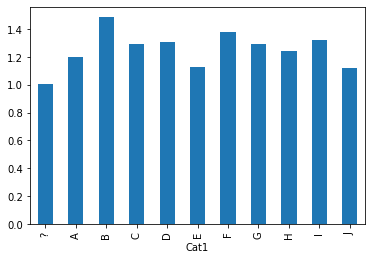

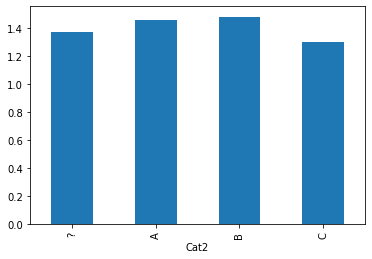

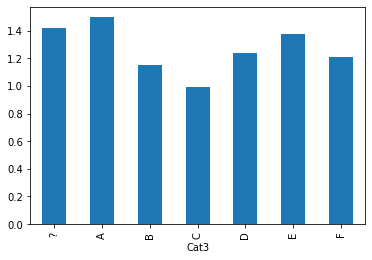

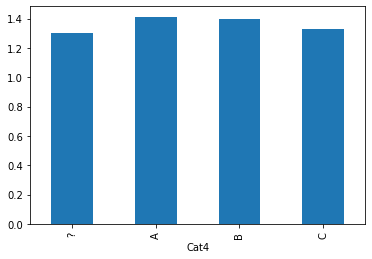

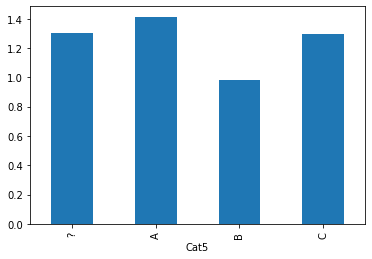

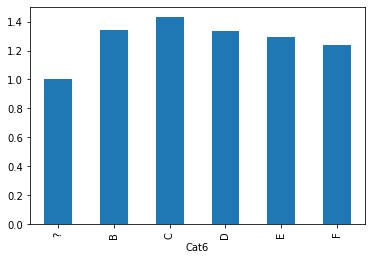

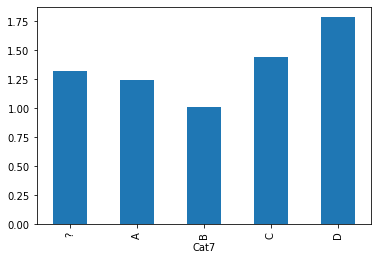

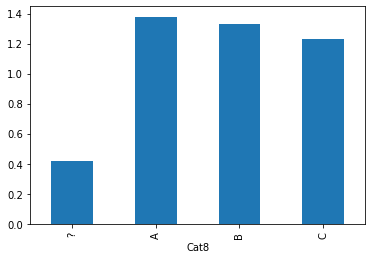

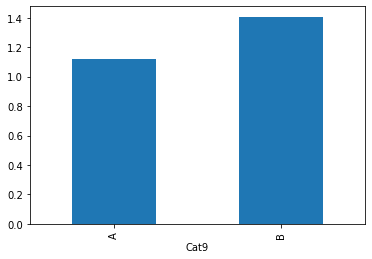

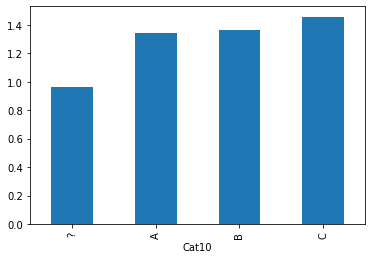

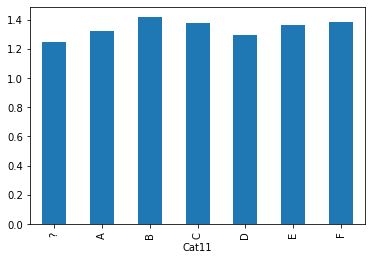

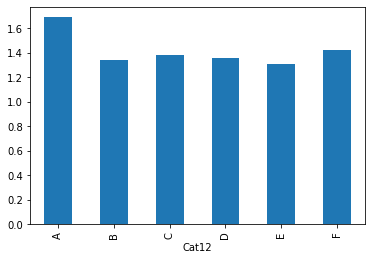

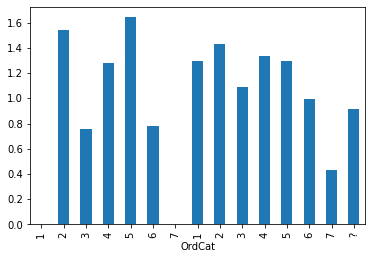

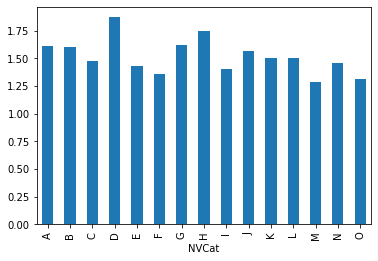

In [59]:
#Plot everything
for col in cols_categorical:
    train_dat.groupby(col).mean()['Claim_Amount'].plot(kind = 'bar')
    plt.show()

In [66]:
# select predictors
preds_categorical = [e for e in cols_categorical if e not in ('Cat2', 'Cat4','OrdCat')]
print(preds_categorical)

['Cat1', 'Cat3', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'NVCat']


In [88]:
# Apply one-hot encoding -- these will enter model later

X_categorical = pd.get_dummies(train_dat, columns = preds_categorical).loc[:,'Cat1_?':]
X_categorical.head()

,Cat1_?,Cat1_A,Cat1_B,Cat1_C,Cat1_D,Cat1_E,Cat1_F,Cat1_G,Cat1_H,Cat1_I,...,NVCat_F,NVCat_G,NVCat_H,NVCat_I,NVCat_J,NVCat_K,NVCat_L,NVCat_M,NVCat_N,NVCat_O
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Numeric Vars

In [67]:
cols_numeric = [col for col in dat.columns if 'Var' in col]
print(cols_numeric)

['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4']


In [ ]:
# plot univariate histograms

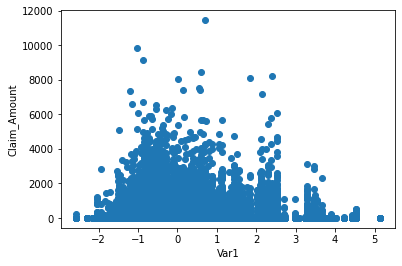

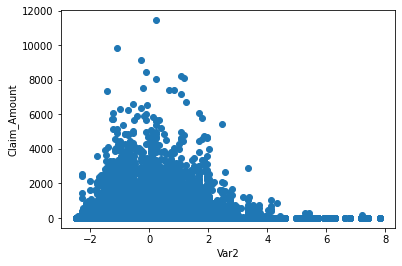

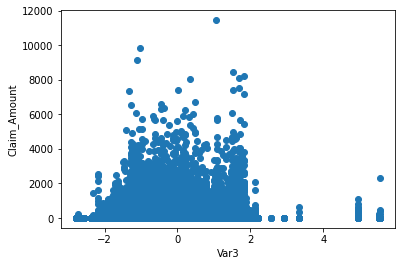

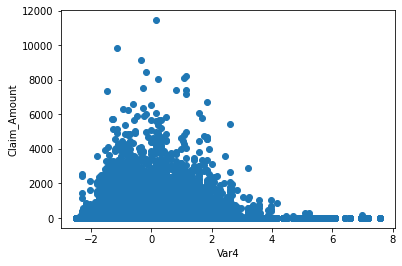

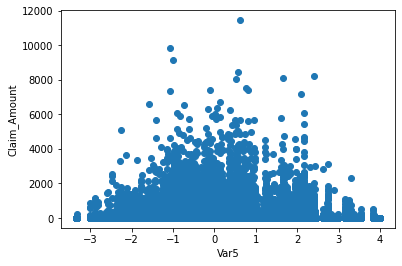

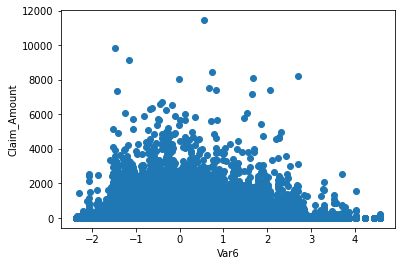

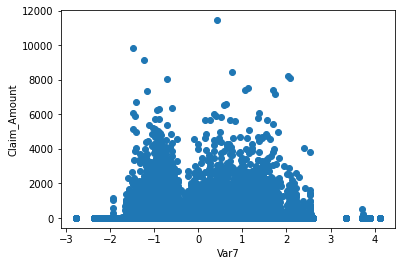

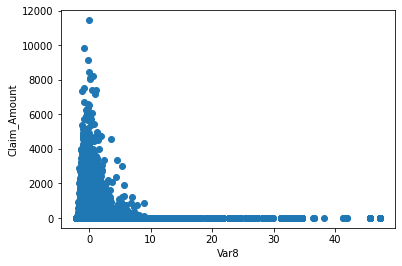

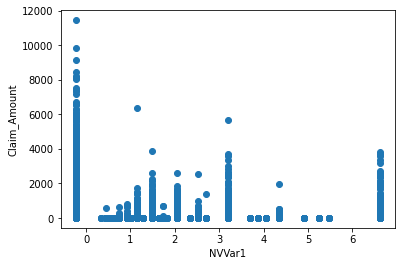

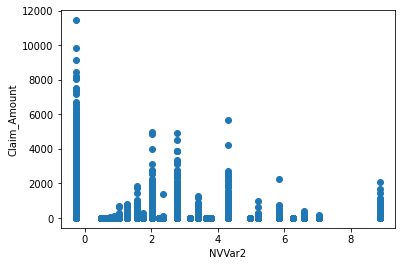

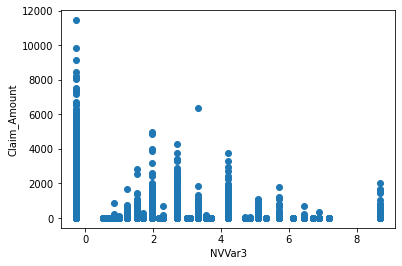

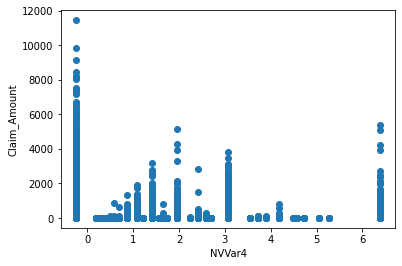

In [70]:
# plot everything nonzero
for col in cols_numeric:
    plt.scatter(train_dat[col], train_dat['Claim_Amount'])
    plt.xlabel(col)
    plt.ylabel("Claim_Amount")
    plt.show()

In [91]:
# Actually I would recommend a lot of work binning these to force linear monotonicity
# BUT-- in the absence of time let's just add the quadratic terms and some interactions and see how we do!

for col in cols_numeric:
    dat[col + '_sqr'] = dat[col]**2

In [95]:
train_dat = dat[dat['FOLD'] >= 6]

In [97]:
train_dat.columns

Index(['Row_ID', 'Household_ID', 'Vehicle', 'Calendar_Year', 'Model_Year',
       'Blind_Make', 'Blind_Model', 'Blind_Submodel', 'Cat1', 'Cat2', 'Cat3',
       'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11',
       'Cat12', 'OrdCat', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6',
       'Var7', 'Var8', 'NVCat', 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4',
       'Claim_Amount', 'Claim', 'FOLD', 'Var1_sqr', 'Var2_sqr', 'Var3_sqr',
       'Var4_sqr', 'Var5_sqr', 'Var6_sqr', 'Var7_sqr', 'Var8_sqr',
       'NVVar1_sqr', 'NVVar2_sqr', 'NVVar3_sqr', 'NVVar4_sqr'],
      dtype='object')

In [78]:
preds_numeric = [col for col in dat.columns if 'Var' in col ]
print(preds_numeric)

['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4', 'Var1_sqr', 'Var2_sqr', 'Var3_sqr', 'Var4_sqr', 'Var5_sqr', 'Var6_sqr', 'Var7_sqr', 'Var8_sqr', 'NVVar1_sqr', 'NVVar2_sqr', 'NVVar3_sqr', 'NVVar4_sqr']


In [99]:
X_numeric = train_dat[preds_numeric]
X_numeric.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVVar1,NVVar2,...,Var3_sqr,Var4_sqr,Var5_sqr,Var6_sqr,Var7_sqr,Var8_sqr,NVVar1_sqr,NVVar2_sqr,NVVar3_sqr,NVVar4_sqr
6,0.700049,0.221317,1.050960,0.147235,0.580718,0.551128,0.416289,-0.024395,-0.23153,-0.266117,...,1.104518,0.021678,0.337233,0.303742,0.173296,0.000595,0.053606,0.070818,0.074168,0.063211
7,0.017076,0.221317,0.333610,0.231803,0.527193,-0.023200,-0.701884,0.226663,-0.23153,-0.266117,...,0.111296,0.053733,0.277933,0.000538,0.492641,0.051376,0.053606,0.070818,0.074168,0.063211
8,0.017076,0.221317,0.333610,0.231803,0.527193,-0.023200,-0.701884,0.226663,-0.23153,-0.266117,...,0.111296,0.053733,0.277933,0.000538,0.492641,0.051376,0.053606,0.070818,0.074168,0.063211
15,-0.376638,-0.245544,-1.239933,-0.309435,-0.763337,-0.101570,0.354851,0.596961,-0.23153,-0.266117,...,1.537433,0.095750,0.582683,0.010317,0.125919,0.356363,0.053606,0.070818,0.074168,0.063211
16,-0.376638,-0.245544,-1.239933,-0.309435,-0.763337,-0.101570,0.354851,0.596961,-0.23153,-0.266117,...,1.537433,0.095750,0.582683,0.010317,0.125919,0.356363,0.053606,0.070818,0.074168,0.063211


## Model Fitting

In [102]:
y = train_dat['Claim']
X = pd.concat([X_categorical, X_numeric], axis = 1)

In [103]:
# Try two step model -- first logistic regression to predict claim, then conditional on claim use gamma to predict severity

logistic_model = sm.GLM(y,X, family=sm.families.Binomial())

MissingDataError: exog contains inf or nans